# Linear Regression

Given a set of $m$ training examples $\left(x^{(i)}, y^{(i)}\right)$ for all $i\in[1,\ldots,m]$, a linear regression model is a supervised learning regression model which expresses $f(x^{(i)})=\hat{y}^{(i)}$ as a linear function of $x^{(i)}$ given parameters $w$ and $b$ as follows:
$$
    \hat{y}^{(i)}=w\cdot x^{(i)}+b
$$

The model is a supervised learning model because the training set contains the "*right*" or expected output value for the target variable for every $x^{(i)}$, and a regression model because the model outputs a continuous value.

Linear regression with one variable is known as a *univariate* linear regression, i.e, $x^{(i)}\in\mathbb{R}$ while *multivariate* linear regression is one wherein $x^{(i)}\in\mathbb{R}^{n}$ for $n>1$ features.

## Cost Function
The goal of the linear regression model is to find optimal parameters $\vec{w}$ and $b$ such that for every training example $\left(x^{(i)}, y^{(i)}\right)$ for $i\in[1,\ldots,m]$
$$
f(x^{(i)})\approx y^{(i)}
$$
Therefore, it helps to provide a precise measure of how *far off* the predicted outputs are from the expected output. This can be formalized as a cost function $J$. A useful cost function for linear regression is the *mean squared error*,
$$
J(w,b)=\frac{1}{2m}\sum_{i=1}^{m}\left(\hat{y}^{(i)} - y^{(i)}\right)^2
$$
The purpose of the $\frac{1}{m}$ is that as gets larger, the value of the cost function gets larger as well,
therefore it helps to build a cost function that does not change significantly just because the size of
the dataset increases. The $2m$ simplifies the calculation of the gradient later on.

Given the cost function, the goal is to find optimal parameters $w^*$ and $b^*$ which minimize $J(w,b)$, i.e,
$$
(w^*,b^*)=\min_{w,b}J(w,b)
$$

## Generating a Synthetic Dataset
The code below generates a synthetic dataset, a set of $m\approx$ `keep * total` training examples $\left(x^{(i)}, y^{(i)}\right)$, where $x^{(i)}\in[x_{low},x_{high}]$ for $i\in[1,\ldots,m]$ such that,
$$
y^{(i)}=w_{true}\cdot x^{(i)}+b_{true}+\epsilon\quad\text{where }\epsilon\sim\mathcal{N}(0, 0.01)
$$

In [1]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

np.random.seed(0)

def generate_linear_dataset(w_true, b_true, x_low, x_high, total, keep):
    x_val  = np.linspace(x_low, x_high, num = total)[np.random.rand(total) > (1 - keep)]
    f_true = lambda x : (w_true * x + b_true)
    y_true = f_true(x_val) + 0.1 * np.random.randn(x_val.shape[0])
    train  = np.column_stack([x_val, y_true])
    
    return train

In [2]:
w_true = 0.62
b_true = 0.19

train = generate_linear_dataset(w_true, b_true, x_low = -1.0, x_high = 1.0, total = 100, keep = 0.5)
train.shape

(49, 2)

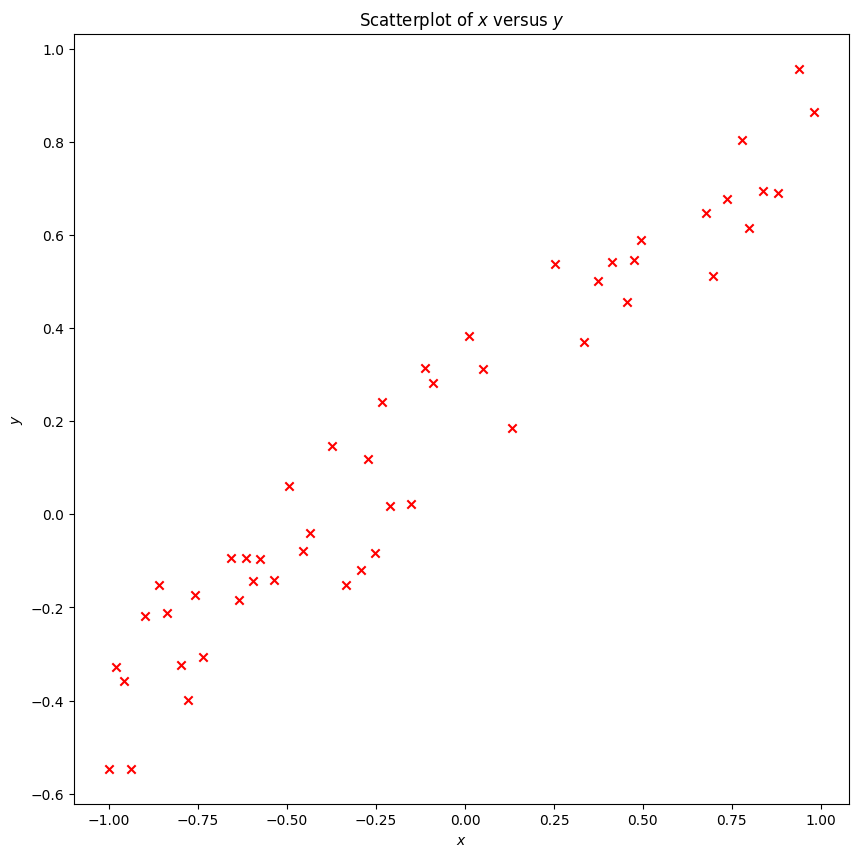

In [3]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(train[:, 0], train[:, 1], marker = 'x', c = 'red')
plt.title ('Scatterplot of $x$ versus $y$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

## Visualizing the Cost Function

In [4]:
x = np.arange(-10, 10, 0.1)
y = np.arange(-10, 10, 0.1)
Z = np.zeros((x.shape[0], y.shape[0]))

for i, w in enumerate(x):
    for j, b in enumerate(y):
        y_pred  = w * train[:, 0] + b
        y_true  = train[:, 1]
        Z[i, j] = np.mean((y_pred - y_true) ** 2) / 2.0

X, Y = np.meshgrid(x, y)

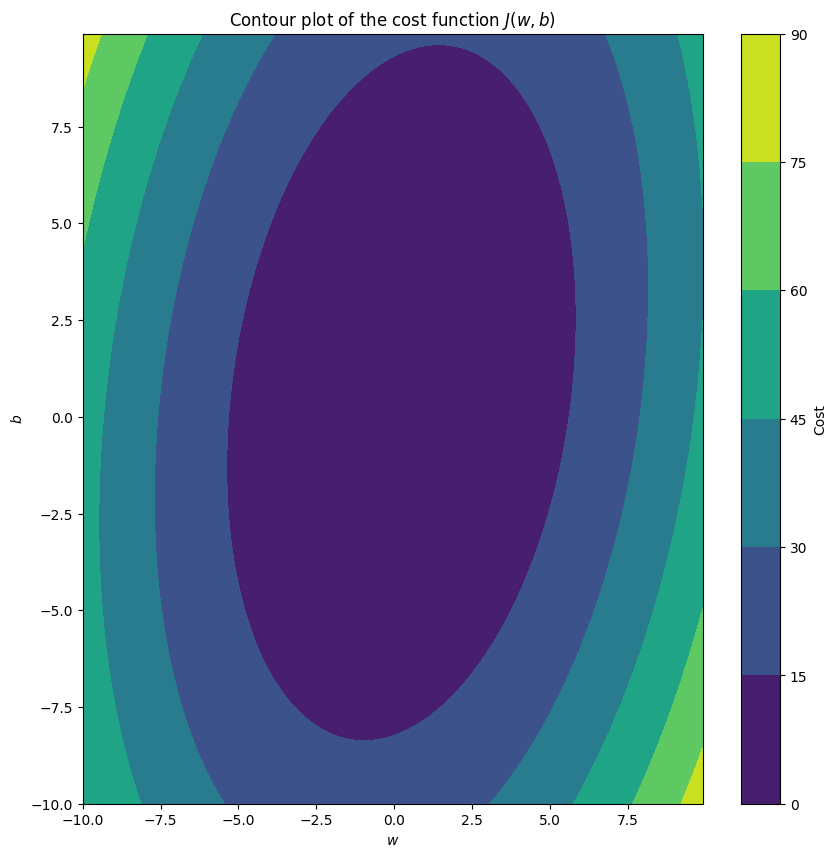

In [5]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches((10, 10))
plt.contourf(X, Y, Z)
plt.xlabel('$w$')
plt.ylabel('$b$')
plt.title ('Contour plot of the cost function $J(w,b)$')
plt.colorbar(label = 'Cost')
plt.show()

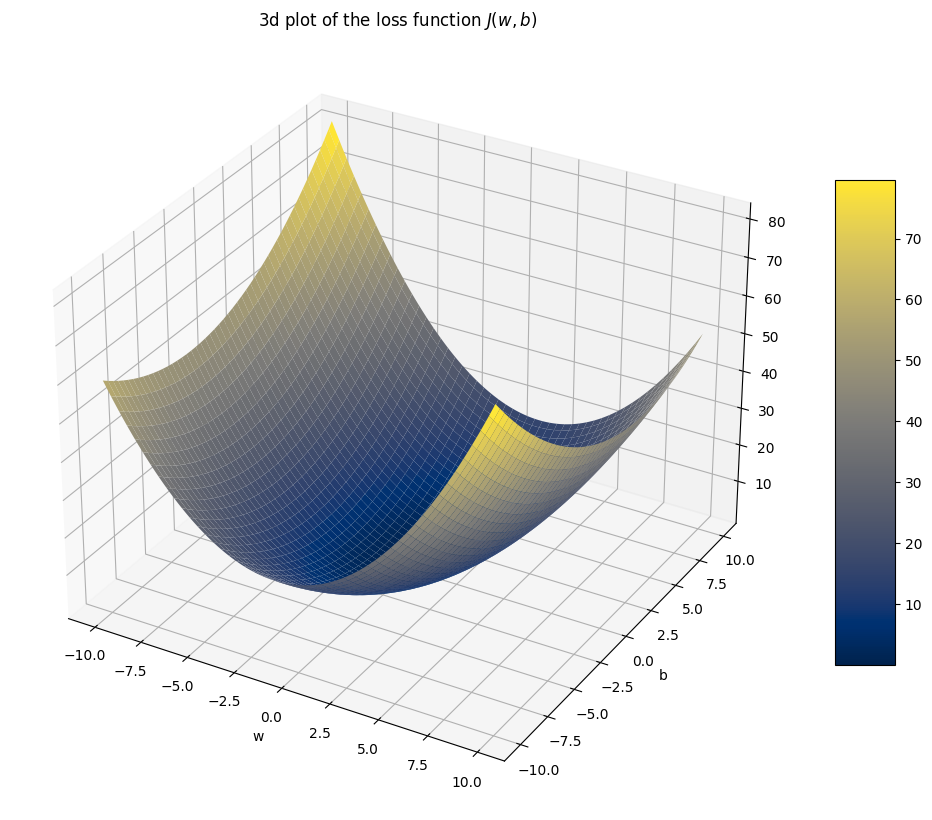

In [6]:
fig = plt.figure(figsize = (10, 10))
ax  = plt.axes(projection = '3d')

surface = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)
fig.colorbar(surface, shrink = 0.5, aspect = 8)
plt.title('3d plot of the loss function $J(w, b)$')
plt.xlabel('w')
plt.ylabel('b')
plt.tight_layout()
plt.show()

## Gradient Descent
Gradient descent is an iterative algorithm that allows for a linear regression model -- and many other more complex deep learning models -- to arrive at a minimum of any continuous and differentiable function.

The idea is that given $w$ and $b$ which are initialized in any manner, the algorithm will continuously update these parameters in the steepest direction (negative of the gradient) towards a minimum of the cost function. This iteration is repeated until convergence.

Note that since the mean squared error cost function is *convex*, any local minimum is also the global minimum. This is not necessarily true for other cost functions, leading to multiple local minima depending on the initial starting point.

The parameters $w$ and $b$ on the $k$-th iteration are continuously updated (simultaneously) as follows,
$$
\begin{align*}
    w^{[k+1]}&\leftarrow w^{[k]}-\alpha\frac{\partial J(w^{[k]},b^{[k]})}{\partial w^{[k]}}\\
    b^{[k+1]}&\leftarrow b^{[k]}-\alpha\frac{\partial J(w^{[k]},b^{[k]})}{\partial b^{[k]}}
\end{align*}
$$
where $\alpha$ describes the *learning rate*, essentially a hyperparameter.

### Derivation of the Gradient
Given the cost function $J(w,b)$ which has been previously defined as,
$$
J(w,b)=\frac{1}{2m}\sum_{i=1}^{m}\left(\hat{y}^{(i)}-y^{(i)}\right)^2
$$
The gradient of the cost function w.r.t the weights $w$ is
$$
\nabla_{w}J(w,b)=\frac{\partial J(w,b)}{\partial w}
$$
The components of this gradient (where $w_j=w$ in the univariate case and $j\in[1,\ldots,n]$ for the multivariate case) can be calculated as,
$$
\begin{align*}
    \frac{\partial J(w,b)}{\partial w}
    &=\frac{\partial}{\partial w}\left[\frac{1}{2m}\sum_{i=1}^{m}\left(\hat{y}^{(i)}-y^{(i)}\right)^2\right]\\
    &=\frac{1}{2m}\cdot\sum_{i=1}^{m}\left[\frac{\partial}{\partial w}\left(\hat{y}^{(i)}-y^{(i)}\right)^2\right]\\
    &=\frac{1}{2m}\cdot\sum_{i=1}^{m}\left[2\left(\hat{y}^{(i)}-y^{(i)}\right)\cdot\frac{\partial}{\partial w_j}\left(wx^{(i)}+b-y^{(i)}\right)\right]\\
    &=\frac{1}{2m}\sum_{i=1}^{m}\left[2\left(\hat{y}^{(i)}-y^{(i)}\right)\cdot x^{(i)}\right]\\
    &=\frac{1}{m}\sum_{i=1}^{m}(\hat{y}^{(i)}-y^{(i)})\cdot x^{(i)}
\end{align*}
$$

Likewise, $\frac{\partial J(w,b)}{b}$ can be calculated as 
$$
\frac{\partial J(w,b)}{\partial b}=\frac{1}{m}\sum_{i=1}^{m}\left(\hat{y}^{(i)}-y^{(i)}\right)
$$

## Implementation

In [7]:
def plot_against_fitted_line(x_train, y_train, w, b, title):
    x_pred = np.linspace(x_train.min(), x_train.max())
    y_pred = w * x_pred + b

    fig = plt.figure(figsize=(10, 10))
    plt.scatter(train[:, 0], train[:, 1], marker = 'x', c = 'red')
    plt.plot(x_pred, y_pred)
    plt.title (title)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend(['Training set', 'Best fit line'])
    plt.show()

def calc_gradients(w, b, x_train, y_true, y_pred):
    grad_w = np.dot(y_pred - y_true, x_train)
    grad_b = np.mean((y_pred - y_true))
    
    return grad_w, grad_b

def calc_optimal_params_grad_descent(epochs, learning_rate, x_train, y_train):
    w = np.random.randn(1)
    b = np.random.randn(1)
    L = np.random.randn(epochs)

    x_train = train[:, 0]
    y_train = train[:, 1]

    for i in range(epochs):
        y_pred   = w * x_train + b
        cost_val = np.mean((y_pred - y_true) ** 2) / 2.0
        grad_w, grad_b = calc_gradients(w, b, x_train, y_train, y_pred)
        grad_w, grad_b
        
        L[i] = cost_val

        w = w - learning_rate * grad_w
        b = b - learning_rate * grad_b    

    return w[0], b[0], L

train_x = train[:, 0]
train_y = train[:, 1]

w_gd, b_gd, loss_hist = calc_optimal_params_grad_descent(100, 0.1, train_x, train_y)

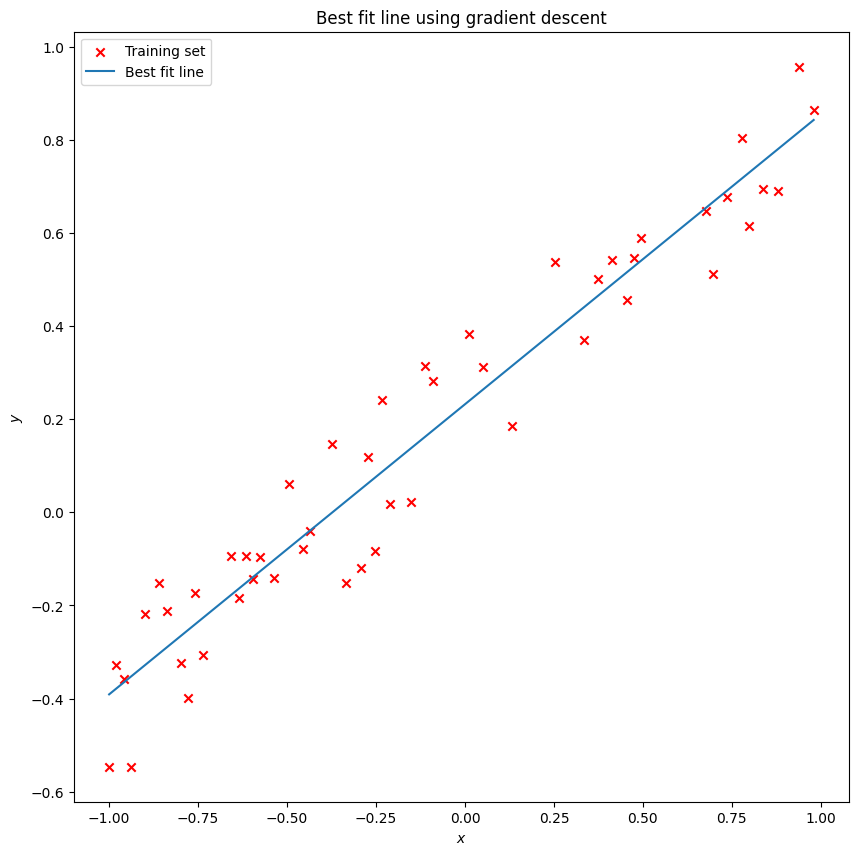

In [8]:
plot_against_fitted_line(train_x, train_y, w_gd, b_gd, 'Best fit line using gradient descent')

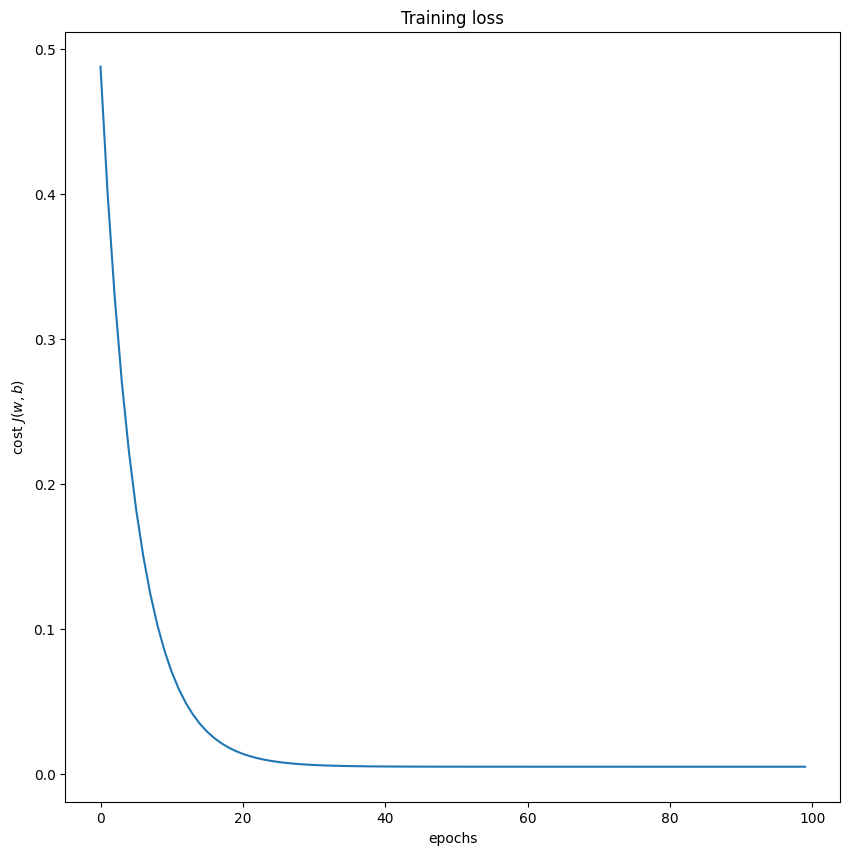

In [9]:
fig = plt.figure(figsize=(10, 10))
plt.xlabel('epochs')
plt.ylabel('cost $J(w,b)$')
plt.title ('Training loss')
plt.plot(loss_hist)
plt.show()

## Direct Solution via System of equations
Given that the mean squared error cost function is a convex function, the minimum can be solved directly by writing the derivatives as a system of equations with two unknowns wherein and finding the solution for $\vec{\theta}=\begin{bmatrix}0, 0\end{bmatrix}^\top$
$$
\begin{align*}
\sum_{i=1}^{m}\left[(w\cdot x^{(i)}+b-y^{(i)})\cdot x^{(i)}\right]&=0\\
\sum_{i=1}^{m}(w\cdot x^{(i)}+b-y^{(i)})       &=0\\
\end{align*}
$$
Expanding terms and transposing constants to the r.h.s
$$
\begin{alignat*}{3}
&(1)\quad w\sum_{i=1}^{m}(x^{(i)})^2&&+b\sum_{i=1}^{m}x^{(i)}&&=\sum_{i=1}^{m}y^{(i)}x^{(i)}\\
&(2)\quad w\sum_{i=1}^{m}x^{(i)}&&+mb&&=\sum_{i=1}^{m}y^{(i)}\\
\end{alignat*}
$$

#### Solving for $w$
Elimination of the second term,
$$
\begin{align*}
w\sum_{i=1}^{m}(x^{(i)})^2+b\sum_{i=1}^{m}x^{(i)}&=\sum_{i=1}^{m}y^{(i)}x^{(i)}\\
-\frac{\sum_{i=1}^{m}x^{(i)}}{m}(w\sum_{i=1}^{m}x^{(i)}+mb       &=\sum_{i=1}^{m}y^{(i)})\\
\end{align*}
$$

$$
\begin{align*}
w\sum_{i=1}^{m}(x^{(i)})^2+b\sum_{i=1}^{m}x^{(i)}&=\sum_{i=1}^{m}y^{(i)}x^{(i)}\\
-w\frac{\left(\sum_{i=1}^{m}x^{(i)}\right)^2}{m}-b\sum_{i=1}^{m}x^{(i)}&=-\frac{\sum_{i=1}^{m}y^{(i)}\sum_{i=1}^{m}x^{(i)}}{m}
\end{align*}
$$

Solving for $w$,
$$
w\left[\frac{m\sum_{i=1}^{m}(x^{(i)})^2-\left(\sum_{i=1}^{m}x^{(i)}\right)^2}{m}\right]=\frac{m\sum_{i=1}^{m}y^{(i)}x^{(i)}-\sum_{i=1}^{m}y^{(i)}\sum_{i=1}^{m}x^{(i)}}{m}
$$

$$
w=\frac{m\sum_{i}y^{(i)}x^{(i)}-\sum_{i}y^{(i)}\sum_{i}x^{(i)}}{m\sum_{i}(x^{(i)})^2-\left(\sum_{i}x^{(i)}\right)^2}
$$

#### Solving for $b$
Solve for $w$ from equation (1) and substitute into equation (2)
$$
w=\frac{\sum_{i}y^{(i)}-bm}{\sum_{i}x^{(i)}}
$$

Solving for $b$,
$$
\begin{align*}
\left(\frac{\sum_{i}y^{(i)}-bm}{\sum_{i}x^{(i)}}\right)\sum_{i}(x^{(i)})^2+b\sum_{i}x^{(i)}&=\sum_{i}y^{(i)}x^{(i)}\\[1em]
\frac{\sum_{i}y^{(i)}\sum_{i}(x^{(i)})^2-mb\sum_{i}(x^{(i)})^2+b\left(\sum_{i}x^{(i)}\right)^2}{\sum_{i}x^{(i)}}&=\sum_{i}y^{(i)}x^{(i)}\\[1em]
\sum_{i}y^{(i)}\sum_{i}(x^{(i)})^2-mb\sum_{i}(x^{(i)})^2+b\left(\sum_{i}x^{(i)}\right)^2&=\sum_{i}y^{(i)}x^{(i)}\cdot\sum_{i}x^{(i)}\\[1em]
-mb\sum_{i}(x^{(i)})^2+b\left(\sum_{i}x^{(i)}\right)^2&=\sum_{i}y^{(i)}x^{(i)}\cdot\sum_{i}x^{(i)}-\sum_{i}y^{(i)}\cdot\sum_{i}(x^{(i)})^2\\[1em]
mb\sum_{i}(x^{(i)})^2-b\left(\sum_{i}x^{(i)}\right)^2&=\sum_{i}y^{(i)}\cdot\sum_{i}(x^{(i)})^2-\sum_{i=1}^{m}y^{(i)}x^{(i)}\cdot\sum_{i}x^{(i)}
\end{align*}
$$
$$
\\[2em]
b=\frac{\sum_{i}y^{(i)}\cdot\sum_{i}(x^{(i)})^2-\sum_{i=1}^{m}y^{(i)}x^{(i)}\cdot\sum_{i}x^{(i)}}{m\sum_{i}(x^{(i)})^2-\left(\sum_{i}x^{(i)}\right)^2}
$$

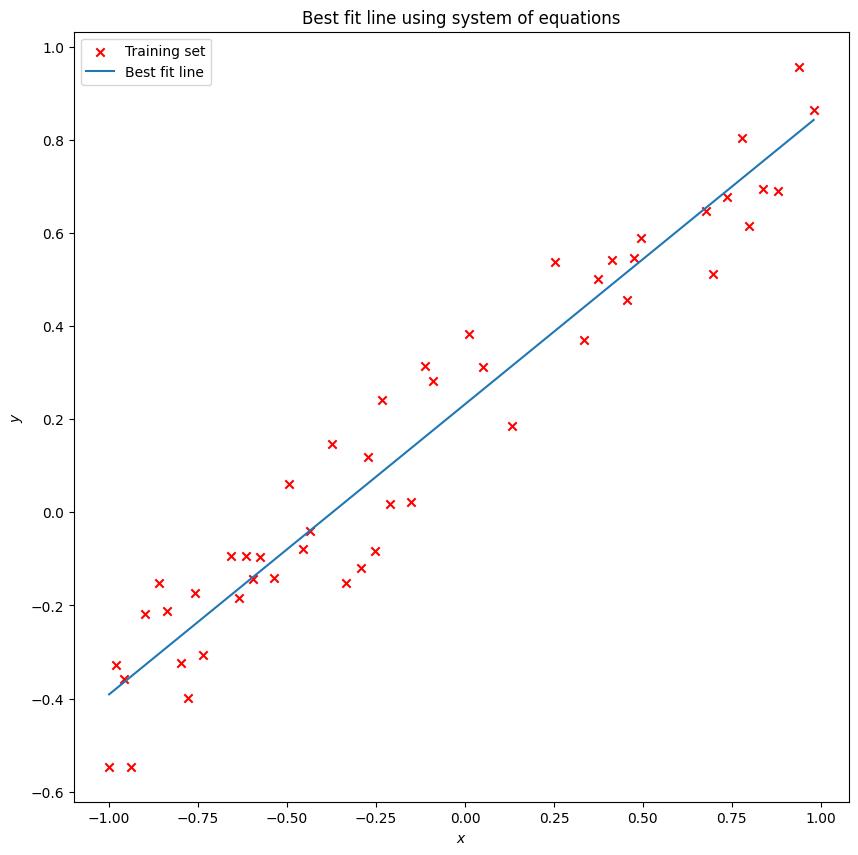

In [10]:
def calc_optimal_params_system_of_eq(x_train, y_train):
    m = x_train.shape[0]

    w_denom = (m * np.sum(x_train ** 2)) - (np.sum(x_train) ** 2)
    w_numer = (m * np.dot(y_train, x_train)) - (np.sum(y_train) * np.sum(x_train))

    w_new = w_numer / w_denom
    w_new

    b_numer = (np.sum(y_train) * np.sum(x_train ** 2)) - (np.dot(y_train, x_train) * np.sum(x_train))
    b_denom = (m * np.sum(x_train ** 2)) - (np.sum(x_train)) ** 2

    b_new = b_numer / b_denom

    return (w_new, b_new)

w_se, b_se = calc_optimal_params_system_of_eq(train_x, train_y)
plot_against_fitted_line(train_x, train_y, w_se, b_se, 'Best fit line using system of equations')

In [11]:
print("Estimated: ({:.5f},{:.5f})".format(w_se, b_se))
print("Descent  : ({:.5f},{:.5f})".format(w_gd, b_gd))
print("True     : ({:.5f},{:.5f})".format(w_true, b_true))

Estimated: (0.62332,0.23228)
Descent  : (0.62331,0.23224)
True     : (0.62000,0.19000)
